In [1]:
import sys
sys.path.insert(0, '../../../pyLDLE2/')
sys.path.insert(0, '../src/')

import numpy as np
import networkx as nx
import ConnectionNetworkX as cnx

from matplotlib import pyplot as plt
from matplotlib import cm

from pyLDLE2 import datasets, visualize_

matplotlib.get_backend() =  module://matplotlib_inline.backend_inline


In [2]:
import importlib
importlib.reload(cnx)

<module 'ConnectionNetworkX' from '/home/dhruv/codebase/cgw/connection-graph-wasserstein/nbks/../src/ConnectionNetworkX.py'>

In [3]:
def draw3d(G, pos, node_color, node_size, edge_color, edge_width=1, figsize=(8,4)):
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    # Create the 3D figure
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, c=node_color, s=node_size, ec="w")

    # Plot the edges
    for i in range(edge_xyz.shape[0]):
        vizedge = edge_xyz[i,:]
        direction = [vizedge[1,0]-vizedge[0,0],
                     vizedge[1,1]-vizedge[0,1],
                     vizedge[1,2]-vizedge[0,2]]
        direction = np.array(direction)
        edge_length = np.linalg.norm(direction)
        direction = direction/edge_length
        ax.quiver(vizedge[0,0], vizedge[0,1], vizedge[0,2],
                  direction[0], direction[1], direction[2],
                  length=edge_length, color=edge_color[i])
        #ax.plot(*vizedge.T, color=edge_color[i], linewidth=edge_width)

    visualize_.set_axes_equal(ax)
    ax.set_xlim(np.min(node_xyz[:,0]), np.max(node_xyz[:,0]))
    ax.set_ylim(np.min(node_xyz[:,1]), np.max(node_xyz[:,1]))
    ax.set_zlim(np.min(node_xyz[:,2]), np.max(node_xyz[:,2]))
    ax.axis('off')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.margins(0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Load data

In [4]:
X, labelsMat, _ = datasets.Datasets().curvedtorus3d(n=3000)

X.shape =  (3000, 3)


<IPython.core.display.Javascript object>


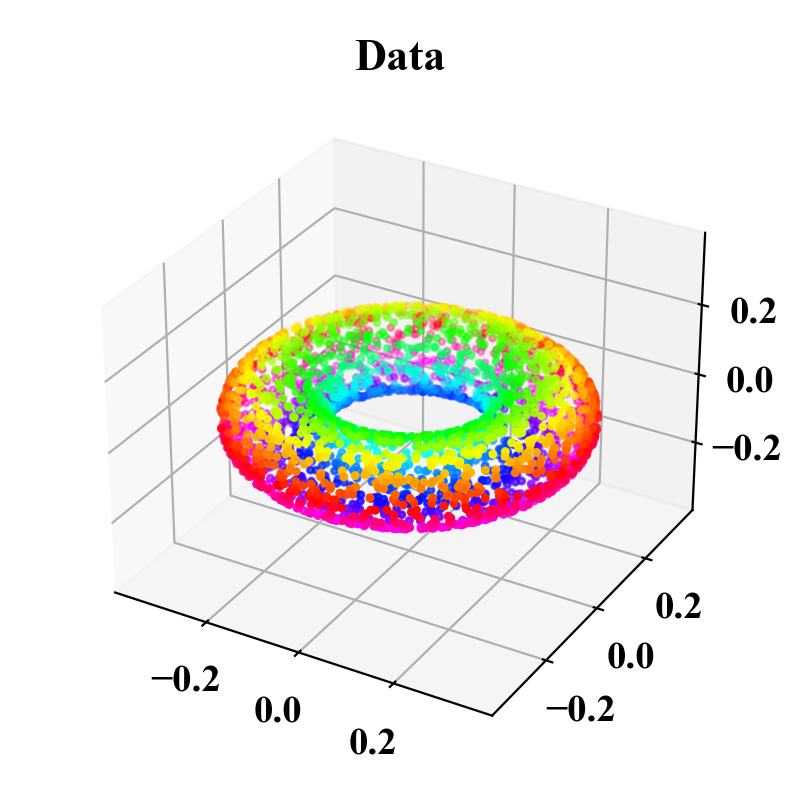

In [5]:
%matplotlib notebook
vis = visualize_.Visualize()
vis.data(X, labelsMat[:,0], cmap='hsv', figsize=(4,4))

# Set source and destination nodes

In [6]:
source = 1300
dest1 = 100
dest2 = 1929

<IPython.core.display.Javascript object>


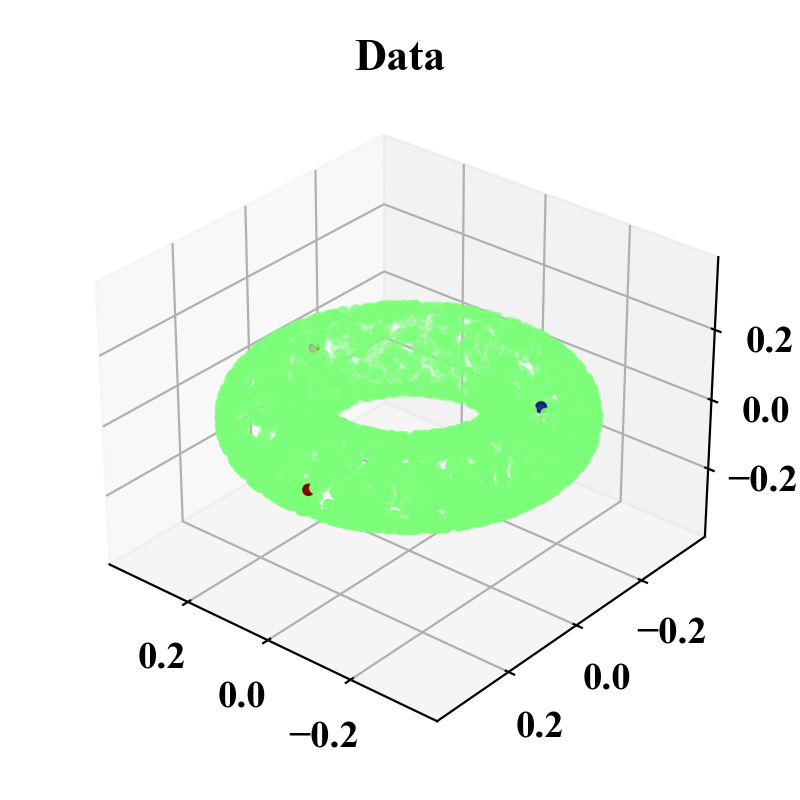

In [7]:
%matplotlib notebook
vis = visualize_.Visualize()
labels = np.zeros(X.shape[0])
labels[source] = -1
labels[dest1] = 1
labels[dest2] = 1
vis.data(X, labels, cmap='jet', figsize=(4,4), s=50, elev=30, azim=130)

#  Build connection graph

In [8]:
eps_pca = 0.03
eps = eps_pca
d = 2
CG = cnx.cnxFromData(X, eps_pca, eps, d=d, tol=1, triv_sigma=False)

Total edges before removal: 12613


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 4062.19it/s]


Proportion of edges which were removed due to remoteness:  0.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:18<00:00, 38.36it/s]


# Set B, w, mu, nu, c

In [9]:
n = CG.number_of_nodes()

B = CG.B.T.astype('float32')
w = np.array(list(nx.get_edge_attributes(CG, 'weight').values()))

mu = np.zeros((n * d, 1))
nu = np.zeros((n * d, 1))
mu[source * d: (source + 1) * d, :] = 1
nu[dest1 * d, :] = 1
nu[dest2 * d+1, :] = 1

c = (mu - nu)

# Plot c

<IPython.core.display.Javascript object>


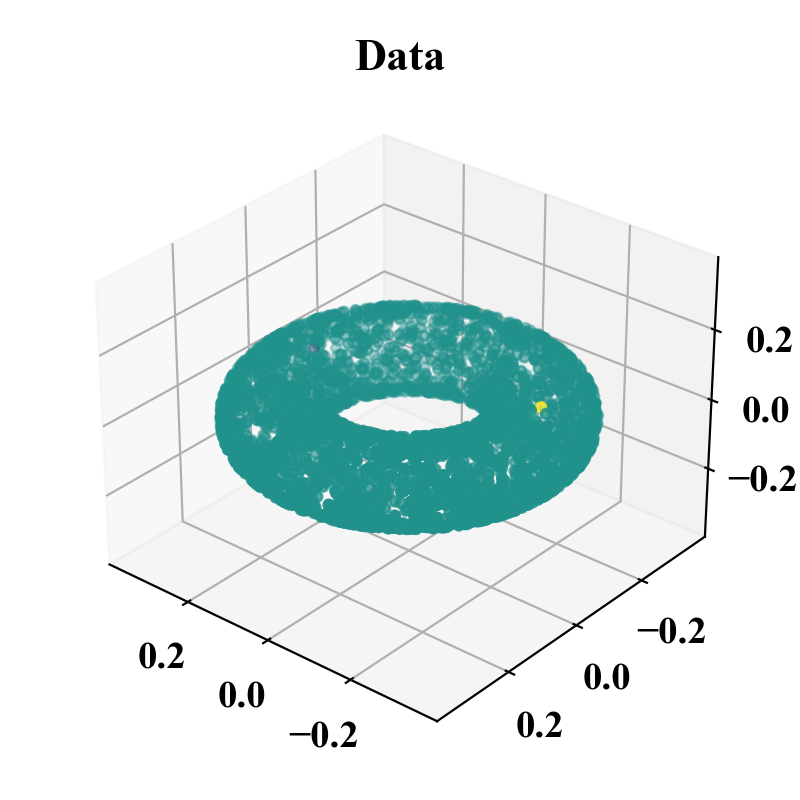

<IPython.core.display.Javascript object>


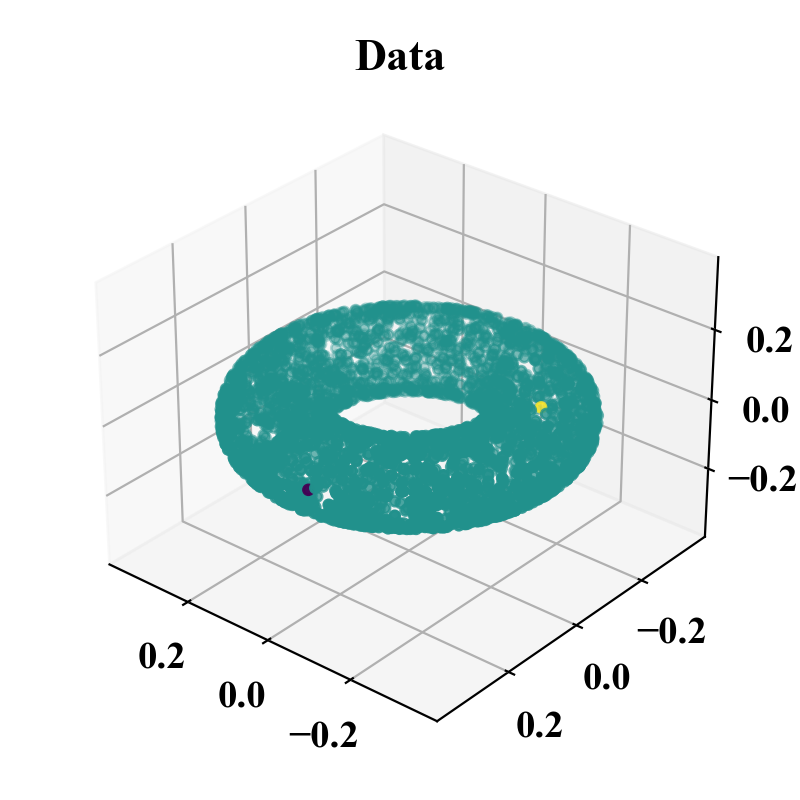

In [10]:
%matplotlib notebook
vis = visualize_.Visualize()
vis.data(X, c.reshape((n,d))[:,0], cmap='viridis', figsize=(4,4), s=50, elev=30, azim=130)
vis.data(X, c.reshape((n,d))[:,1], cmap='viridis', figsize=(4,4), s=50, elev=30, azim=130)

# Check feasibility of primal i.e. $B^TJ = c$

In [11]:
temp_J, residuals, _, _ = np.linalg.lstsq(B.T.toarray(), c, rcond=None)
print('Error is:', np.linalg.norm(c.flatten() - B.T.dot(temp_J).flatten())) # if this is small then feasible

Error is: 1.9236352828184002e-14


In [24]:
np.max(w)

0.16807888389961673

# Solve Beckmann dual using gradient descent

In [25]:
learning_rate = 0.1
alpha = np.max(w)*100
n_epochs = 5000

phi, phi0 = cnx.optimize_(B, w, c, learning_rate=learning_rate, alpha=alpha,
                    n_epochs=n_epochs, phi0='least_squares')

Initial loss: (tensor(-9.7873), tensor(4.4323))
epoch: 0, loss: -9.655482, loss0: -9.787335, loss1: 4.432338
epoch: 10, loss: -13.521373, loss0: -13.785777, loss1: 8.888163
epoch: 20, loss: -17.272526, loss0: -17.771873, loss1: 16.785929
epoch: 30, loss: -20.904411, loss0: -21.730534, loss1: 27.770718
epoch: 40, loss: -24.409536, loss0: -25.650265, loss1: 41.708019
epoch: 50, loss: -27.783539, loss0: -29.523861, loss1: 58.502293
epoch: 60, loss: -31.025845, loss0: -33.346760, loss1: 78.019356
epoch: 70, loss: -34.137596, loss0: -37.116524, loss1: 100.139030
epoch: 80, loss: -37.120609, loss0: -40.831955, loss1: 124.759804
epoch: 90, loss: -39.976250, loss0: -44.492054, loss1: 151.802322
epoch: 100, loss: -42.709698, loss0: -48.095764, loss1: 181.056854
epoch: 110, loss: -45.321995, loss0: -51.642235, loss1: 212.459747
epoch: 120, loss: -47.816154, loss0: -55.130878, loss1: 245.890076
epoch: 130, loss: -50.196663, loss0: -58.561234, loss1: 281.181610
epoch: 140, loss: -52.465855, loss0:

epoch: 1200, loss: -89.327568, loss0: -171.598892, loss1: 2765.614502
epoch: 1210, loss: -89.327652, loss0: -171.630997, loss1: 2766.690918
epoch: 1220, loss: -89.327858, loss0: -171.661057, loss1: 2767.694336
epoch: 1230, loss: -89.328125, loss0: -171.689194, loss1: 2768.631348
epoch: 1240, loss: -89.328362, loss0: -171.715530, loss1: 2769.508545
epoch: 1250, loss: -89.328506, loss0: -171.740158, loss1: 2770.331543
epoch: 1260, loss: -89.328461, loss0: -171.763153, loss1: 2771.106201
epoch: 1270, loss: -89.328590, loss0: -171.784683, loss1: 2771.825684
epoch: 1280, loss: -89.328583, loss0: -171.804779, loss1: 2772.501465
epoch: 1290, loss: -89.328339, loss0: -171.823486, loss1: 2773.138428
epoch: 1300, loss: -89.328674, loss0: -171.840973, loss1: 2773.715088
epoch: 1310, loss: -89.328873, loss0: -171.857300, loss1: 2774.257080
epoch: 1320, loss: -89.328972, loss0: -171.872528, loss1: 2774.765869
epoch: 1330, loss: -89.328857, loss0: -171.886719, loss1: 2775.246582
epoch: 1340, loss: -

epoch: 2380, loss: -89.329399, loss0: -172.066437, loss1: 2781.269775
epoch: 2390, loss: -89.329361, loss0: -172.066544, loss1: 2781.274658
epoch: 2400, loss: -89.329185, loss0: -172.066620, loss1: 2781.283203
epoch: 2410, loss: -89.329002, loss0: -172.066666, loss1: 2781.290771
epoch: 2420, loss: -89.329277, loss0: -172.066696, loss1: 2781.282471
epoch: 2430, loss: -89.329369, loss0: -172.066711, loss1: 2781.280029
epoch: 2440, loss: -89.329323, loss0: -172.066742, loss1: 2781.282471
epoch: 2450, loss: -89.329079, loss0: -172.066757, loss1: 2781.291260
epoch: 2460, loss: -89.329071, loss0: -172.066742, loss1: 2781.291016
epoch: 2470, loss: -89.329224, loss0: -172.066742, loss1: 2781.285889
epoch: 2480, loss: -89.329163, loss0: -172.066727, loss1: 2781.287598
epoch: 2490, loss: -89.329292, loss0: -172.066727, loss1: 2781.283203
epoch: 2500, loss: -89.329338, loss0: -172.066727, loss1: 2781.281494
epoch: 2510, loss: -89.329193, loss0: -172.066727, loss1: 2781.286377
epoch: 2520, loss: -

epoch: 3560, loss: -89.328835, loss0: -172.066284, loss1: 2781.283691
epoch: 3570, loss: -89.323280, loss0: -172.066422, loss1: 2781.474854
epoch: 3580, loss: -89.326263, loss0: -172.066269, loss1: 2781.369629
epoch: 3590, loss: -89.325470, loss0: -172.065155, loss1: 2781.358887
epoch: 3600, loss: -89.327469, loss0: -172.064636, loss1: 2781.274170
epoch: 3610, loss: -89.327209, loss0: -172.064606, loss1: 2781.281738
epoch: 3620, loss: -89.326996, loss0: -172.064560, loss1: 2781.287354
epoch: 3630, loss: -89.328003, loss0: -172.064423, loss1: 2781.249023
epoch: 3640, loss: -89.325714, loss0: -172.064880, loss1: 2781.341309
epoch: 3650, loss: -89.326187, loss0: -172.065216, loss1: 2781.336670
epoch: 3660, loss: -89.328270, loss0: -172.064560, loss1: 2781.244629
epoch: 3670, loss: -89.328735, loss0: -172.064255, loss1: 2781.218750
epoch: 3680, loss: -89.328461, loss0: -172.064774, loss1: 2781.245361
epoch: 3690, loss: -89.329117, loss0: -172.065109, loss1: 2781.234619
epoch: 3700, loss: -

epoch: 4750, loss: -89.329239, loss0: -172.066879, loss1: 2781.290039
epoch: 4760, loss: -89.329285, loss0: -172.066849, loss1: 2781.287354
epoch: 4770, loss: -89.329254, loss0: -172.066849, loss1: 2781.288574
epoch: 4780, loss: -89.329292, loss0: -172.066864, loss1: 2781.287842
epoch: 4790, loss: -89.329338, loss0: -172.066864, loss1: 2781.286133
epoch: 4800, loss: -89.329239, loss0: -172.066864, loss1: 2781.289551
epoch: 4810, loss: -89.329124, loss0: -172.066849, loss1: 2781.292969
epoch: 4820, loss: -89.329208, loss0: -172.066833, loss1: 2781.289551
epoch: 4830, loss: -89.329254, loss0: -172.066818, loss1: 2781.287598
epoch: 4840, loss: -89.329376, loss0: -172.066849, loss1: 2781.284424
epoch: 4850, loss: -89.329361, loss0: -172.066849, loss1: 2781.284912
epoch: 4860, loss: -89.329132, loss0: -172.066879, loss1: 2781.293701
epoch: 4870, loss: -89.329140, loss0: -172.066879, loss1: 2781.293457
epoch: 4880, loss: -89.329315, loss0: -172.066818, loss1: 2781.285400
epoch: 4890, loss: -

# Compute activeness of edges and optimal primal

In [26]:
edge_score = cnx.activenes_of_edges(phi, B, w, c)
J_opt = cnx.optimal_primal(phi, B, w, c, alpha, d) # the mean abs error should be small

mean abs err of sum_{v in V} ||(B^TJ-c)(v)||_1 0.0013677463737331284


In [27]:
J_opt_norm = np.linalg.norm(J_opt, axis=1)

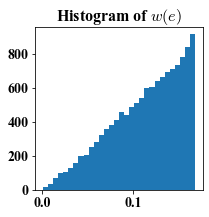

In [28]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(list(nx.get_edge_attributes(CG, "weight").values()), bins=30)
plt.title('Histogram of $w(e)$')
plt.show()

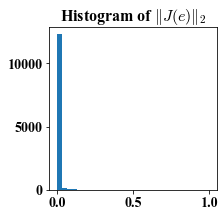

In [29]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(J_opt_norm, bins=30)
plt.title('Histogram of $\\left\\|J(e)\\right\\|_2$')
plt.show()

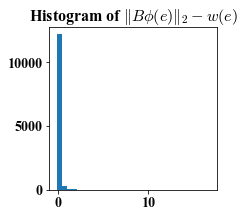

In [30]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(edge_score, bins=30)
plt.title('Histogram of $\\left\\|B\\phi(e)\\right\\|_2-w(e)$')
plt.show()

# Plot optimal flow

In [31]:
from sklearn.manifold import LocallyLinearEmbedding, Isomap

to_embed = None # no need to embed if the data is already in <= 3 dimensions, else use isomap/ltsa
embed_dim = None
if to_embed is not None:
    if to_embed == 'isomap':
        fit_obj = Isomap(n_components=embed_dim, n_neighbors=10)
    else:
        fit_obj = LocallyLinearEmbedding(n_components=embed_dim, n_neighbors=10, method='ltsa')
    embedding = fit_obj.fit_transform(X)
else:
    embedding = X

In [32]:
J = J_opt

<IPython.core.display.Javascript object>


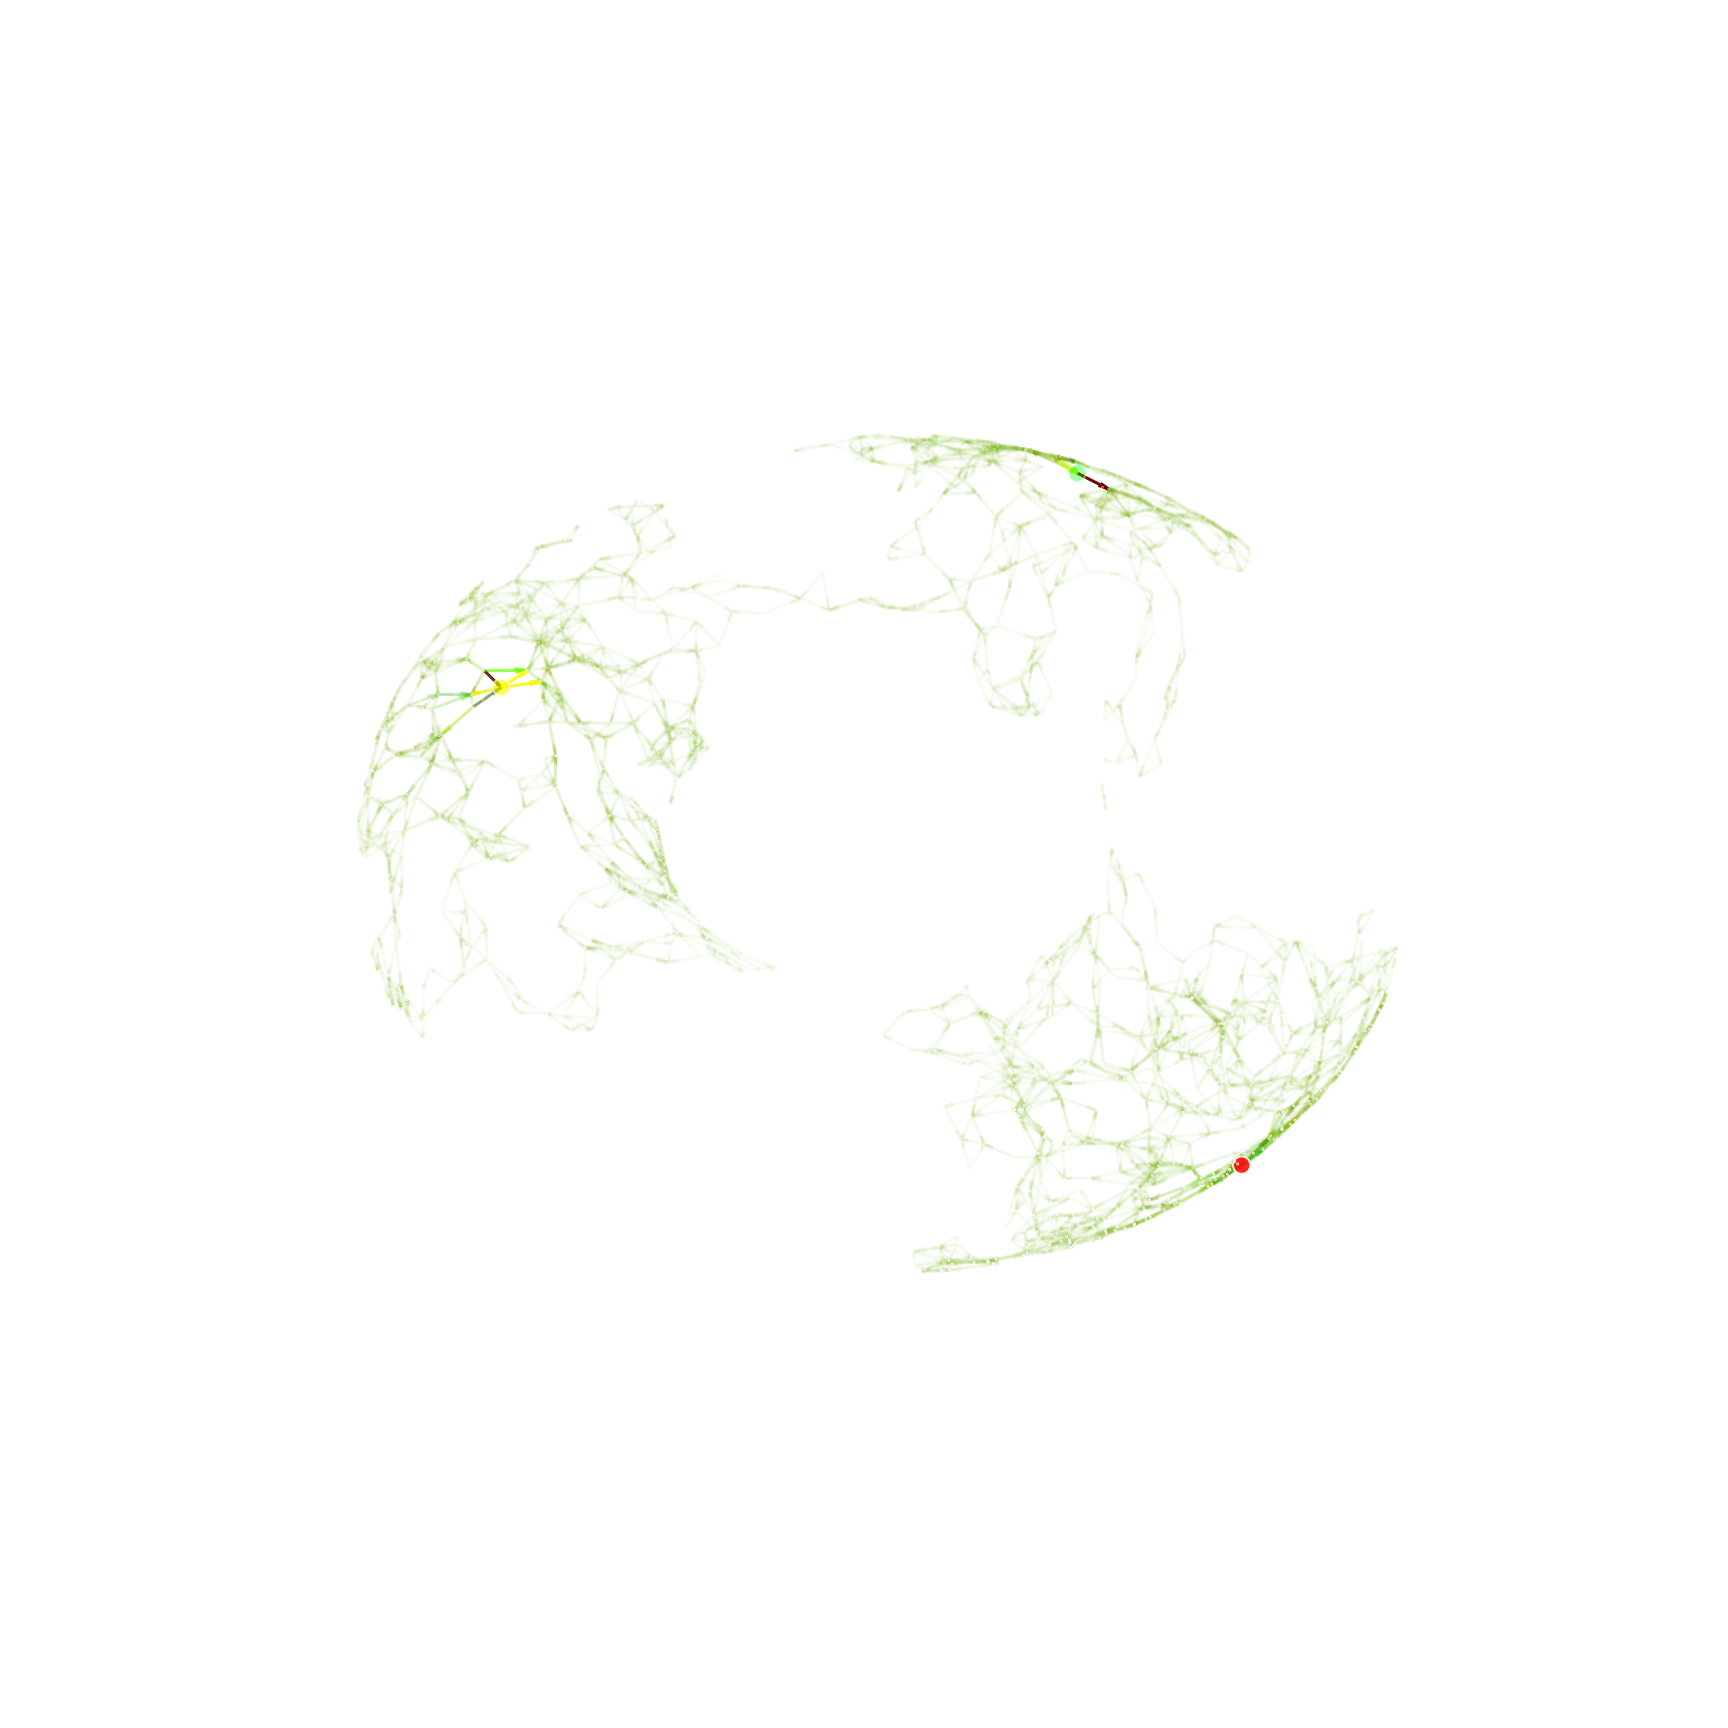

/tmp/ipykernel_66843/1841123288.py:32: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [33]:
%matplotlib notebook

node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300

node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,1,0,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,1,0,1]

mask = (edge_score > 0)
J_ = J[mask,:]

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,0] = cm.Greys((J_[:,0]-np.min(J_[:,0]))/np.ptp(J_[:,0]))[:,0]
edge_color[mask,1] = cm.Greys((J_[:,1]-np.min(J_[:,1]))/np.ptp(J_[:,1]))[:,1]
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=5, figsize=(12, 12))
#plt.gca().view_init(elev=20, azim=-119)
visualize_.set_axes_equal(plt.gca())
plt.show()

<IPython.core.display.Javascript object>


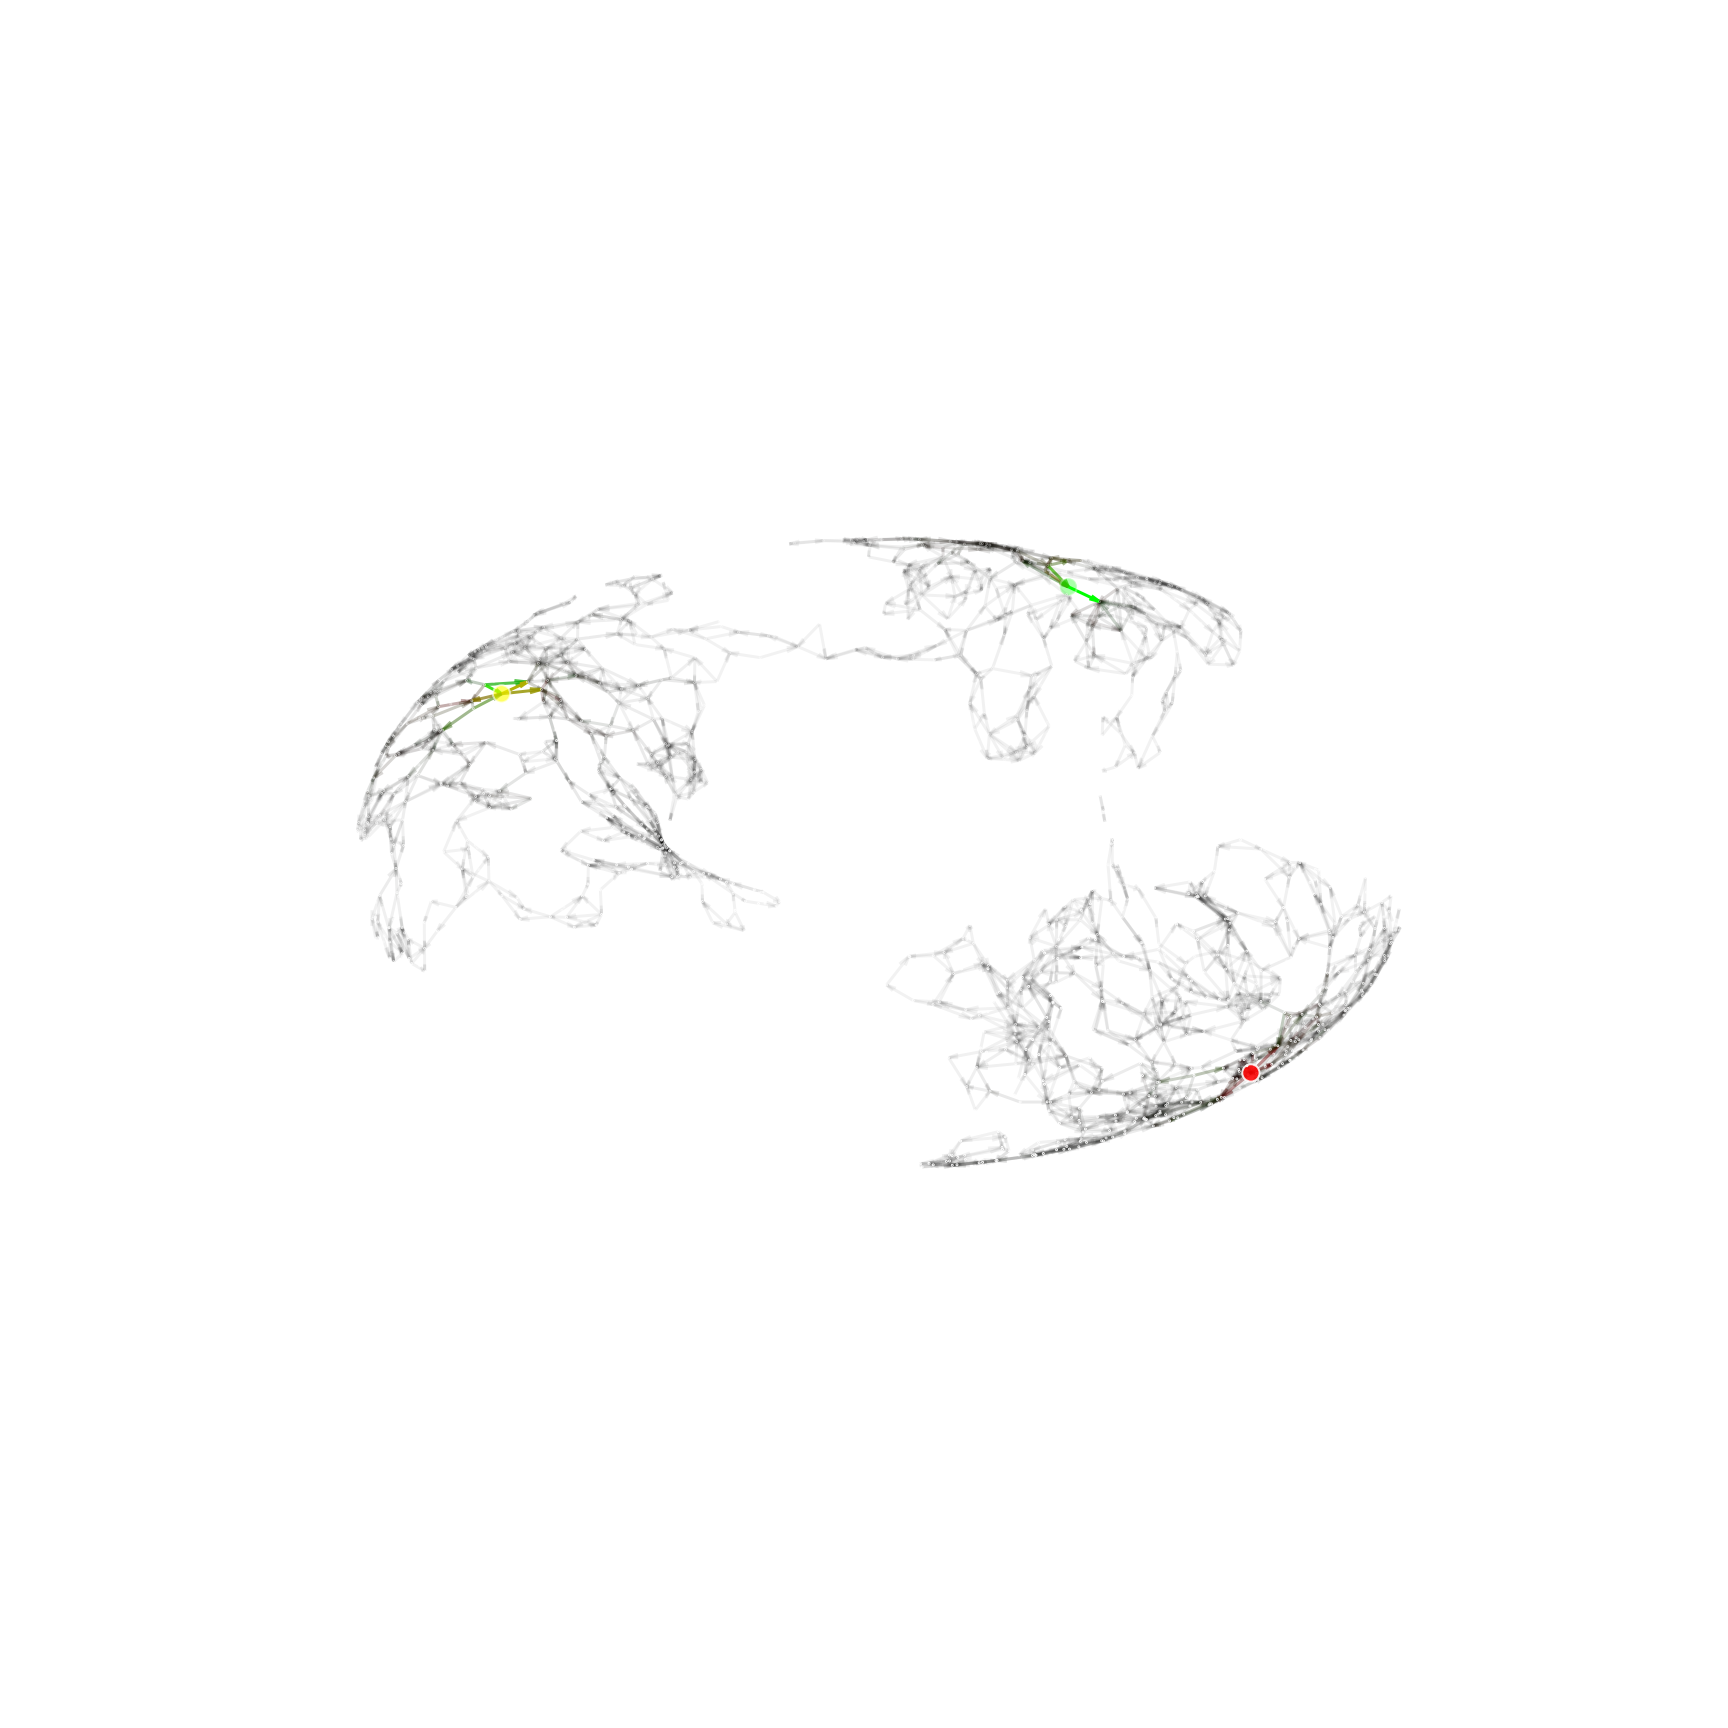

/tmp/ipykernel_66843/1841123288.py:32: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [34]:
%matplotlib notebook
node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300

node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,1,0,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,1,0,1]

mask = (edge_score > 0)
J_ = J[mask,:]
mJ_ = np.max(np.abs(J_))

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,0] = np.abs(J_[:,0])/mJ_
edge_color[mask,1] = np.abs(J_[:,1])/mJ_
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=5, figsize=(12, 12))
#plt.gca().view_init(elev=20, azim=-119)
visualize_.set_axes_equal(plt.gca())
plt.show()

# Plot optimal phi

In [35]:
node_color_ = phi.reshape((CG.number_of_nodes(), d))

<IPython.core.display.Javascript object>


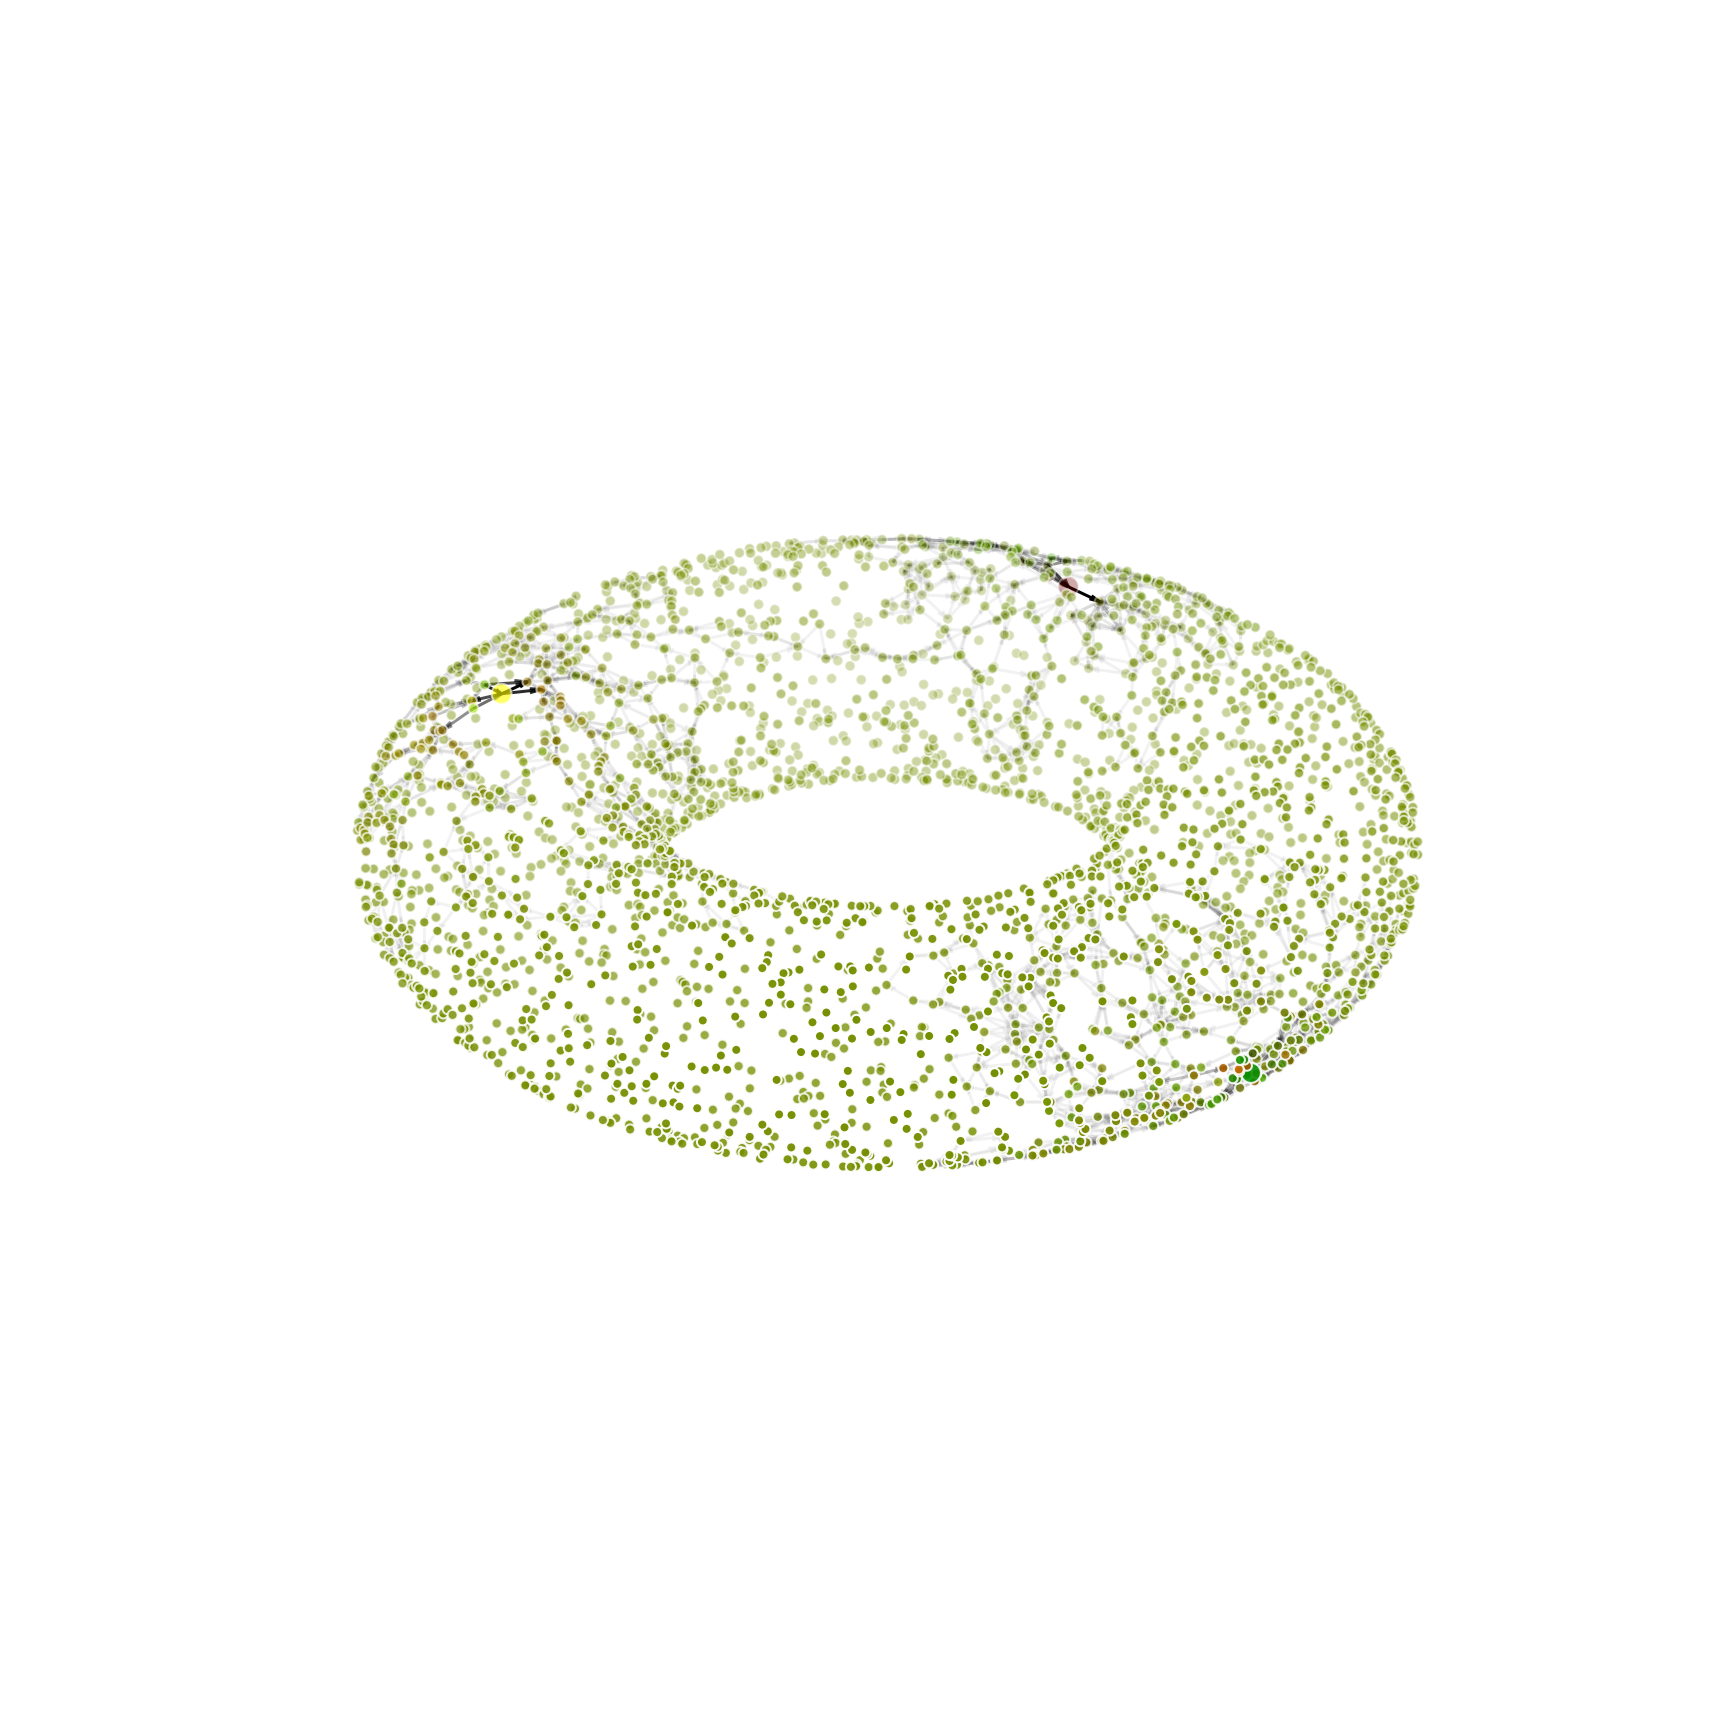

/tmp/ipykernel_66843/1841123288.py:32: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [36]:
%matplotlib notebook
node_size = np.ones(n)*100
node_size[source] = 400
node_size[dest1] = 400
node_size[dest2] = 400

node_color = np.zeros((n,4))
node_color[:,-1] = 1
node_color[:,0] = (node_color_[:,0] - np.min(node_color_[:,0]))/np.ptp(node_color_[:,0])
node_color[:,1] = (node_color_[:,1] - np.min(node_color_[:,1]))/np.ptp(node_color_[:,1])

mask = (edge_score > 0)

edge_color = np.zeros((edge_score.shape[0],4))
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=5, figsize=(12, 12))
#plt.gca().view_init(elev=20, azim=-119)
visualize_.set_axes_equal(plt.gca())
plt.show()